In [1]:
#Import necessary libraries
#Handle data frames
import pandas as pd
#Handle geo data frames (data frames with geometry)
import geopandas as gpd
#Operations on geometries
import shapely
from shapely.geometry import Polygon, Point
from shapely import speedups
from shapely.ops import unary_union
#Fast vectorized operations
import shapely.vectorized as sv
#Arrays and maths
import numpy as np
import math
#Handle netCDF4 data
import xarray as xr
#Plotting
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib as mpl
from matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import Normalize
from matplotlib import cm
import matplotlib.dates as mdates
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import metpy.calc as mpcalc
import seaborn as sns
#Interactive plots
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from datetime import datetime
from os import listdir
from openpyxl.workbook import Workbook
import warnings
warnings.filterwarnings('ignore')
#warnings.filterwarnings(action='once')
#sns.set()
%matplotlib inline

In [2]:
#Define paths for Hydrobasin and Precipitations data
path = "C:/Users/Jérôme/Documents/Master UniBe/Cours/Master Thesis/Data/Hydrobasin"
path2 = "C:/Users/Jérôme/Documents/Master UniBe/Cours/Master Thesis/Data/World/ERA5"
out_dir = "C:/Data/"

In [3]:
#Create Hydrobasin world map
hybas_af = gpd.read_file(path + "/hybas_lake_af_lev01-06_v1c/hybas_lake_af_lev06_v1c.shp")
hybas_ar = gpd.read_file(path + "/hybas_lake_ar_lev01-06_v1c/hybas_lake_ar_lev06_v1c.shp")
hybas_as = gpd.read_file(path + "/hybas_lake_as_lev01-06_v1c/hybas_lake_as_lev06_v1c.shp")
hybas_au = gpd.read_file(path + "/hybas_lake_au_lev01-06_v1c/hybas_lake_au_lev06_v1c.shp")
hybas_eu = gpd.read_file(path + "/hybas_lake_eu_lev01-06_v1c/hybas_lake_eu_lev06_v1c.shp")
hybas_gr = gpd.read_file(path + "/hybas_lake_gr_lev01-06_v1c/hybas_lake_gr_lev06_v1c.shp")
hybas_na = gpd.read_file(path + "/hybas_lake_na_lev01-06_v1c/hybas_lake_na_lev06_v1c.shp")
hybas_sa = gpd.read_file(path + "/hybas_lake_sa_lev01-06_v1c/hybas_lake_sa_lev06_v1c.shp")
hybas_si = gpd.read_file(path + "/hybas_lake_si_lev01-06_v1c/hybas_lake_si_lev06_v1c.shp")
#Select only the necessary columns from Hydrobasin dataframe
hybas_data = hybas_af.append([hybas_ar,hybas_as,hybas_au,hybas_eu,hybas_gr,hybas_na,hybas_sa,hybas_si])
hybas_data_gdf = hybas_data[['HYBAS_ID','SUB_AREA','LAKE','COAST','ENDO','geometry']]
#Create mapping for region
key_continent = np.arange(1,10)
continent = dict(zip(key_continent, ["AF","EU","SI","AS","AU","SA","NA","AR","GR"]))

In [4]:
#Select main HydroBASIN region and columns to import
region = '2'
r = '2'
w = '14'
t = '99'
th = 't' + t
thn = th + 'n'
pkt = "PKt" + t + "n" + w
tpw = 'TPw' + w
name = 'eps_r'+r+th+'w'+w+'_'+continent[int(region)]+'.csv'
basin = 2060548280

In [5]:
#Search episode of interest
eps = pd.read_csv(path2 + '/' + name,usecols=["HYBAS_ID", "time", "N1", "N2",tpw,pkt])
eps['time'] = pd.to_datetime(eps['time'])
sel = eps.loc[(eps['HYBAS_ID']==basin),].nlargest(50,[pkt])

In [6]:
#Load precipitation time series, accumulations, count of extreme events and quantiles
path_tw = path2 + "/tw_r" + r + "_" + continent[int(region)] + "_midlat.csv"
evt_data = pd.read_csv(path_tw, usecols=["HYBAS_ID", "time", "TP",tpw,pkt,thn])
evt_data['time'] = pd.to_datetime(evt_data['time'])
path_qt = path2 + "/quantiles_" + continent[int(region)] + ".csv"
qt = pd.read_csv(path_qt)
qt = qt.loc[qt['Threshold']==th]
evt_data = evt_data.merge(qt[['HYBAS_ID','TP']],on=['HYBAS_ID'],suffixes=('',th),how='inner')
nm = 'TP'+th
evt_data.rename(columns = {nm:'TH'}, inplace = True) 
evt_data = evt_data.loc[(evt_data['HYBAS_ID']==basin),]

In [7]:
data_f = pd.read_csv(path2+'/Catchments_Grid_EU_025dg_lv6.csv', dtype={'HYBAS_ID': 'int64',
                                                           'lon': 'float32', 'lat': 'float32', 'NP': 'int32'})
data_gdf = gpd.GeoDataFrame(data_f.iloc[:,[1,2]],crs='',columns=['lon','lat'],
                            geometry=gpd.points_from_xy(data_f.iloc[:,1],data_f.iloc[:,2]))
data_gdf.crs = {'init':'epsg:4326'}

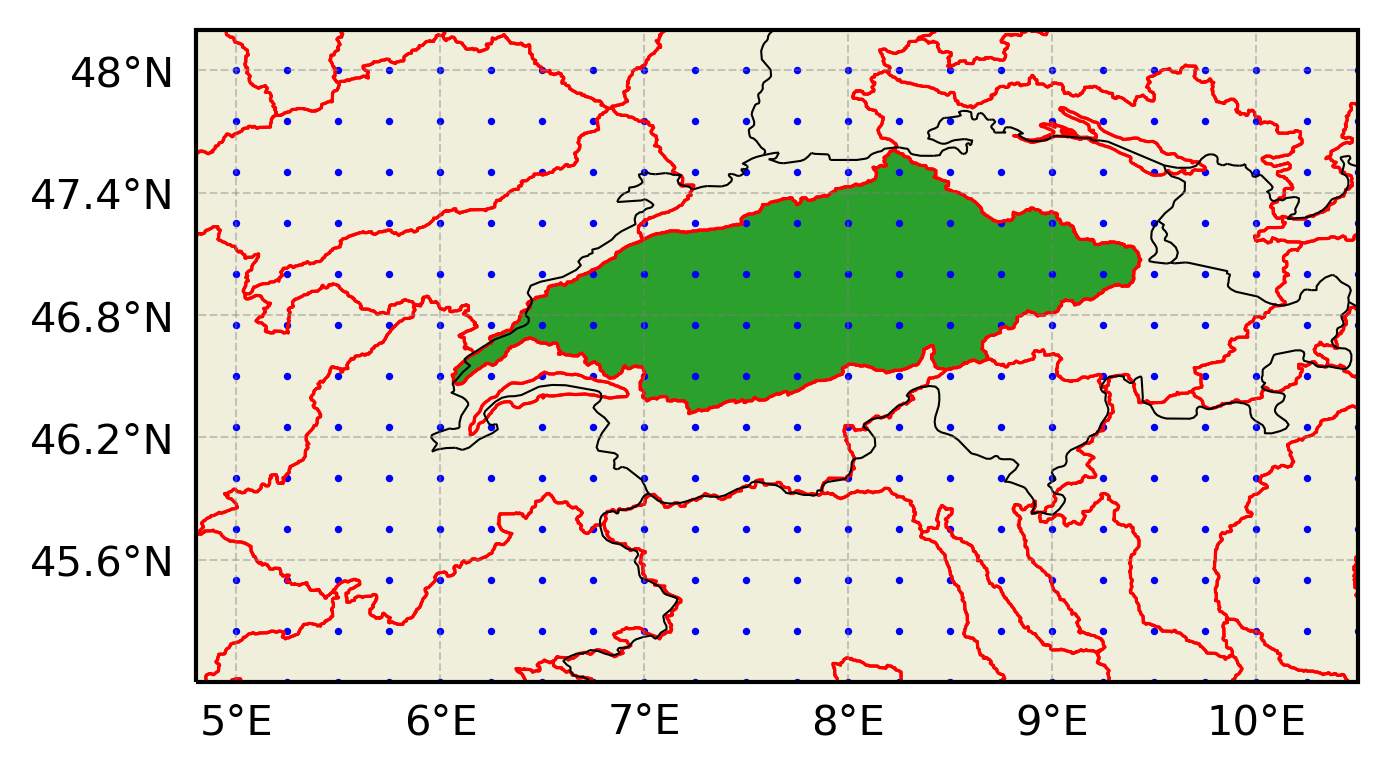

In [8]:
#Plot to visualise catchment location
#Extract catchment and define plot boundaries
#Aare: 2060491750
#Ticino: 2060548280
basin = 2060491750
#basins = (2060654920,2060648560)
bounds = hybas_data_gdf.loc[hybas_data_gdf.HYBAS_ID == basin].geometry.bounds
#bounds = hybas_data_gdf.loc[hybas_data_gdf.HYBAS_ID.isin(basins)].geometry.bounds
lo_min = math.floor(min(bounds.minx))
lo_max = math.ceil(max(bounds.maxx))
la_min = math.floor(min(bounds.miny))
la_max = math.ceil(max(bounds.maxy))

projection=ccrs.PlateCarree()
fig = plt.figure(figsize=(5,5),dpi=300)
ax = plt.axes(projection=projection)
ax.set_extent([lo_min-20,lo_max+10,la_min-20,la_max+10]) # Using catchments coordinates
#ax.set_extent([-10,5,35,45],projection) # Spain case studies
ax.set_extent([4.8,10.5,45,48.2],projection) # Switzerland
#ax.plot(event.x_c,event.y_c,'bo')

hybas_data_gdf.loc[hybas_data_gdf.HYBAS_ID == basin].geometry.plot(ax=ax,color='tab:green')
#hybas_data_gdf.loc[hybas_data_gdf.HYBAS_ID == basins[1]].geometry.plot(ax=ax,color='tab:green')
#hybas_data_gdf.loc[hybas_data_gdf.HYBAS_ID == basins[2]].geometry.plot(ax=ax,color='tab:grey')
#hybas_data_gdf.loc[hybas_data_gdf.HYBAS_ID.isin(basins)].geometry.plot(ax=ax,color='blue')

data_gdf.geometry.centroid.plot(ax=ax,color='blue',markersize=0.6)

hybas_data_gdf.plot(ax=ax,color='none',edgecolor='red',linewidth=0.75,transform=projection)

ax.add_feature(cfeature.BORDERS.with_scale('10m'),linestyle='-',linewidth=0.5)
#ax.add_feature(cfeature.RIVERS.with_scale('10m'),linewidth=0.75,edgecolor='tab:blue')
ax.add_feature(cfeature.LAND.with_scale('10m'))

gl = ax.gridlines(crs=projection, draw_labels=True,linewidth=0.5, color='gray', alpha=0.4, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False
gl.xlabel_style = {'size': 10}
gl.ylabel_style = {'size': 10}
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

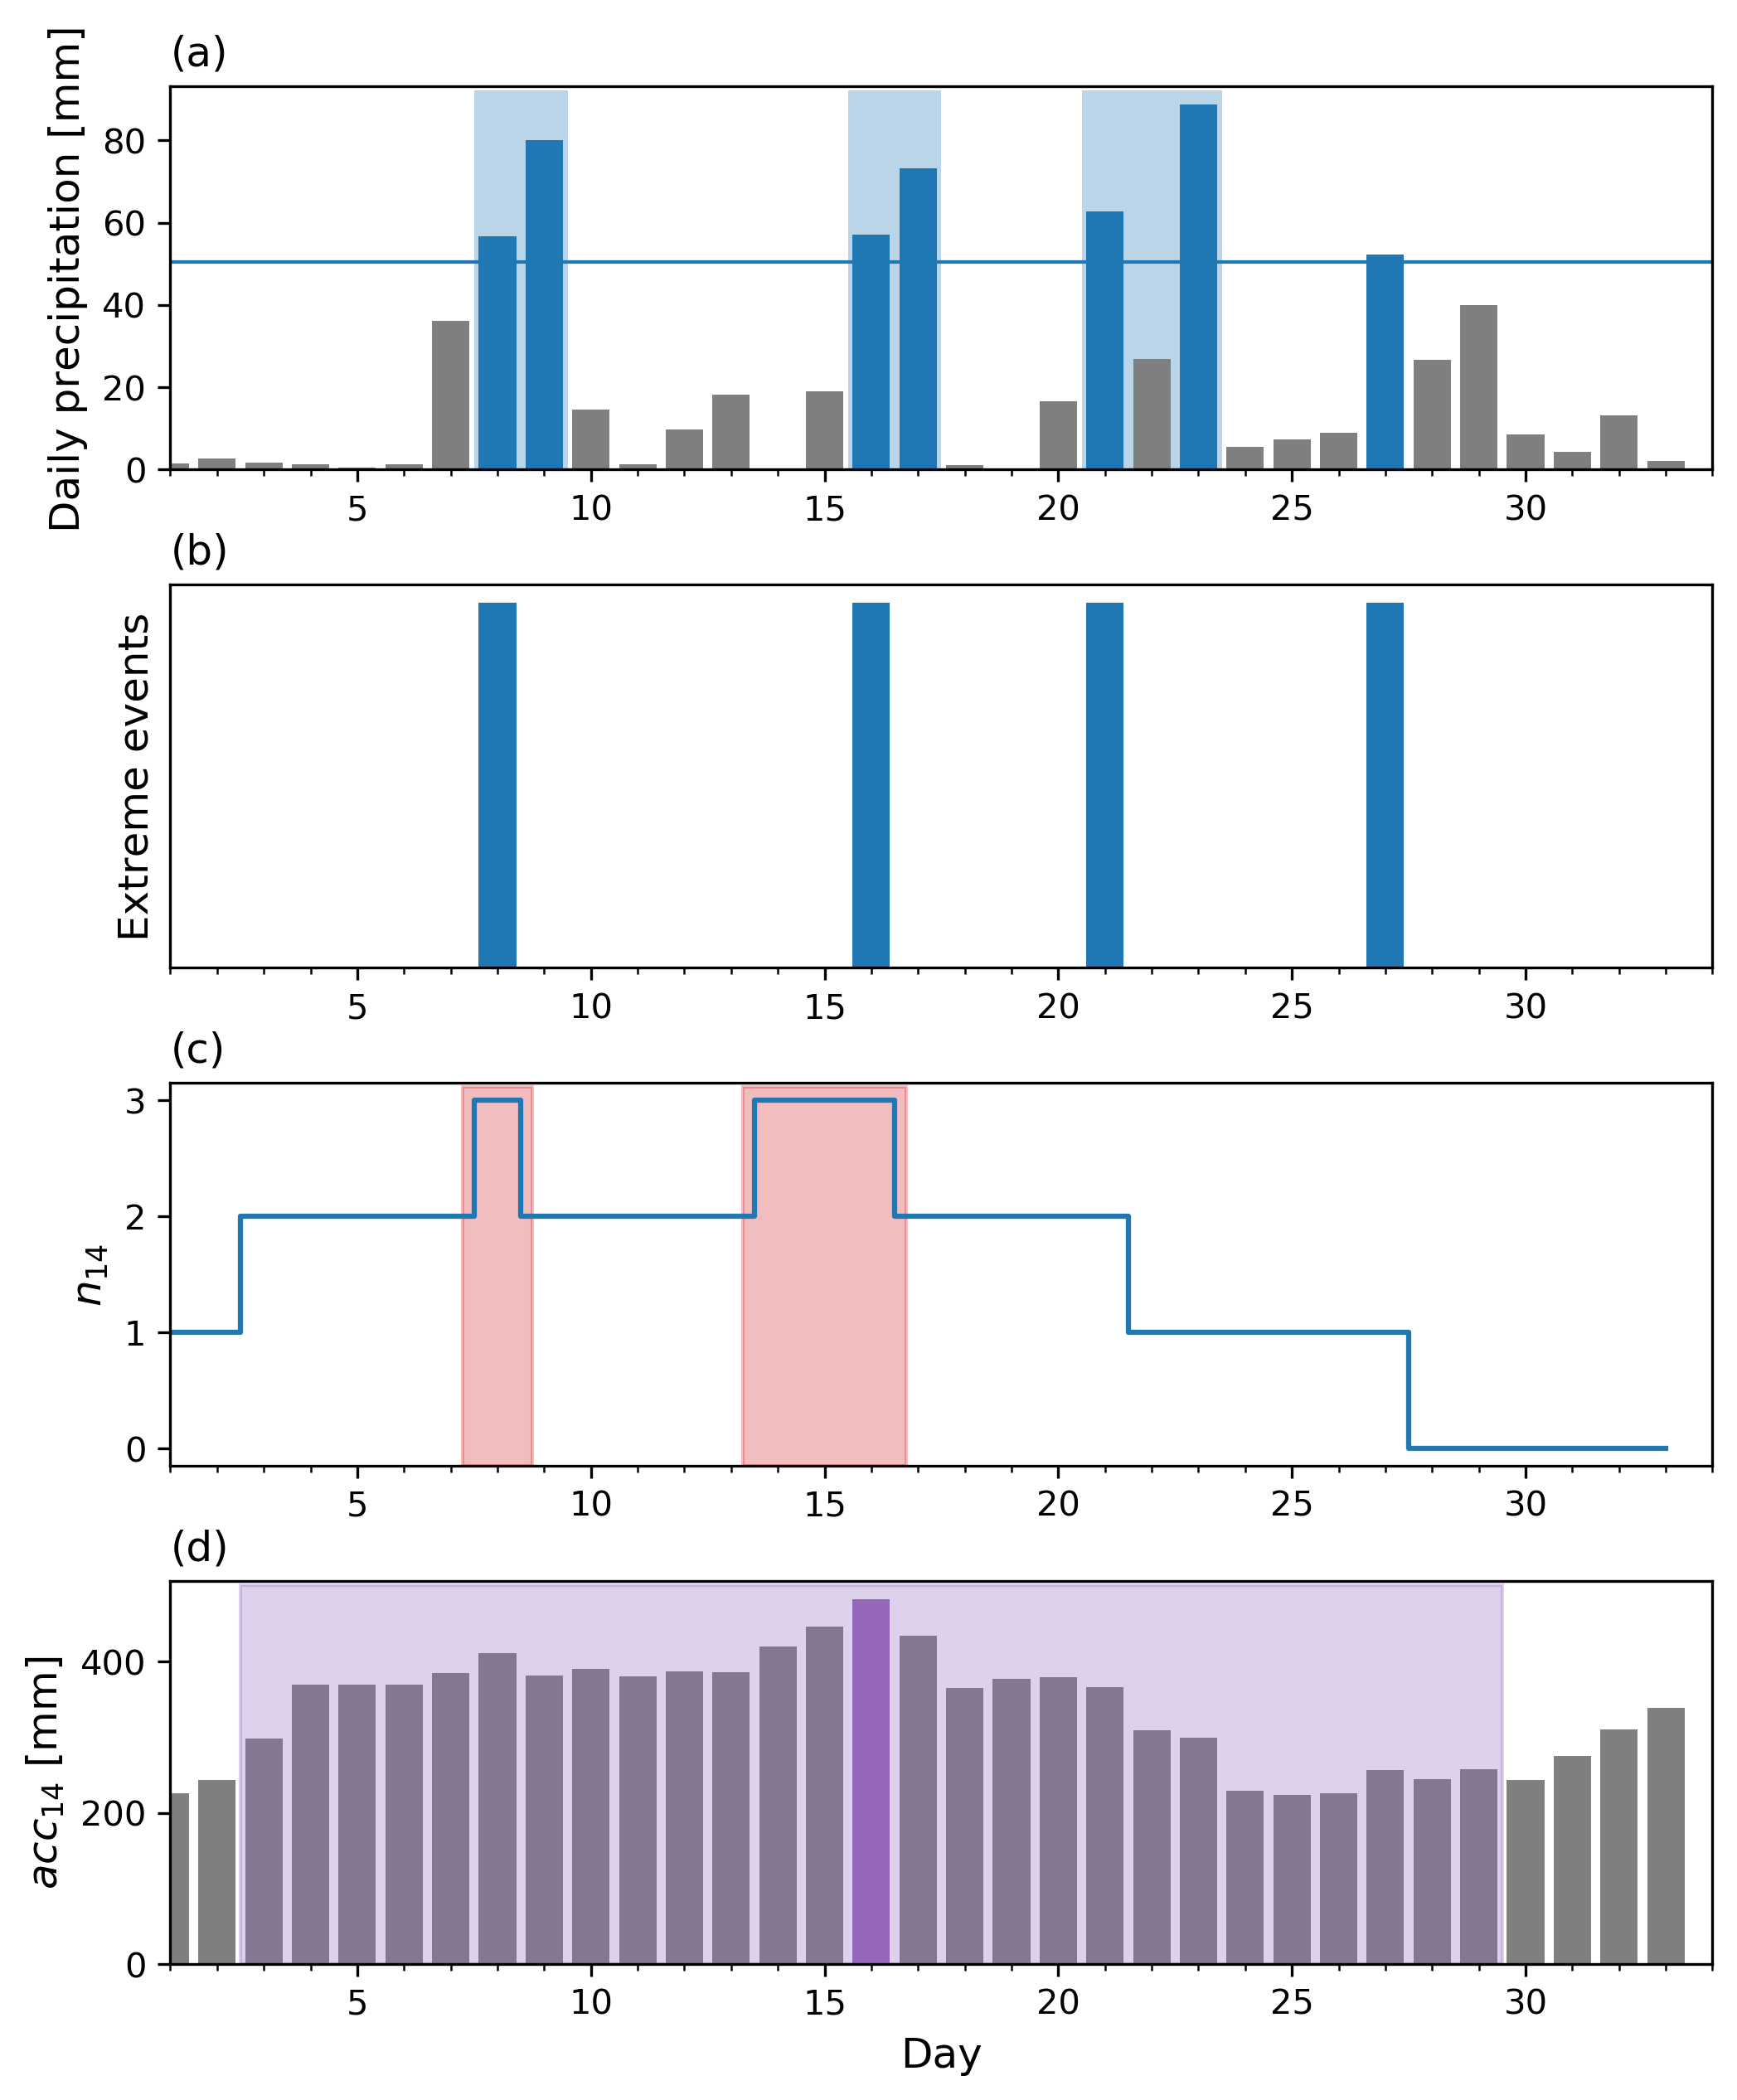

In [9]:
# Event selection
event = sel.iloc[0]
# Create time slice from dates
event['daynum'] = event.time.dayofyear - 258
evt_data['daynum'] = evt_data.time.dt.dayofyear - 258
#eps['daynum'] = eps.time.dt.dayofyear - 258
start_time = event.time - pd.Timedelta(days=15)
end_time = event.time + pd.Timedelta(days=18)
start_day = event.daynum - 15
end_day = event.daynum + 18
time_slice = slice(start_time, end_time)
#Data for precipitations histogram and POT dates
pr_data = evt_data[(evt_data.time >= start_time) & (evt_data.time < end_time)]

fts = 12

#Change time series values for example
TP_change1 = -15
TP_change2 = 40
dates = ('1993-10-11','1993-10-12','1993-10-13','1993-10-14','1993-10-15','1993-10-16','1993-10-17','1993-10-18')
pr_data.loc[pr_data.time==dates[3],['TP']] += TP_change1
for i in range(len(dates)):
    pr_data.loc[pr_data.time == pd.to_datetime(dates[i]),[tpw]] += TP_change2*i

fig = plt.figure(figsize=(8,10),dpi=300,constrained_layout=True)
gs = gridspec.GridSpec(nrows=4, ncols=1,hspace=0.3)#,width_ratios=widths,height_ratios=heights)

#Precipitation Histogram
ax1 = fig.add_subplot(gs[0, 0])
event_POT = pr_data[pr_data.TP >= pr_data.TH]
event_others = pr_data[pr_data.TP < pr_data.TH]
delta = 0.5
plt.axvspan(event_POT['daynum'].iloc[0]-delta,event_POT['daynum'].iloc[1]+delta,alpha=0.3,ymax=0.99)
plt.axvspan(event_POT['daynum'].iloc[2]-delta,event_POT['daynum'].iloc[3]+delta,alpha=0.3,ymax=0.99)
plt.axvspan(event_POT['daynum'].iloc[4]-delta,event_POT['daynum'].iloc[5]+delta,alpha=0.3,ymax=0.99)
ax1.bar(event_POT.daynum, event_POT.TP, align='center')
ax1.bar(event_others.daynum, event_others.TP, align='center',color='tab:grey')
ax1.set_xlim(start_day, end_day)
ax1.set_title('(a)',loc='left')
plt.axhline(y=pr_data['TH'].iloc[0],linewidth=1)
plt.ylabel('Daily precipitation [mm]', fontsize=fts)

#Event Histogram
ax4 = fig.add_subplot(gs[1, 0])
ax4.bar(pr_data.daynum, pr_data[thn], align='center')
ax4.set_xlim(start_day, end_day)
ax4.tick_params(axis='y',which='both',labelleft=False,left=False)
ax4.set_title('(b)',loc='left')
plt.ylabel('Extreme events', fontsize=fts)

#PKw Histogram
delta = 0.75
ax3 = fig.add_subplot(gs[2, 0])
ax3.step(pr_data.daynum, pr_data[pkt],color='tab:blue',where='mid')
plt.axvspan(pr_data['daynum'].iloc[7]-delta,pr_data['daynum'].iloc[7]+delta,alpha=0.3,ymax=0.99,color='tab:red')
plt.axvspan(pr_data['daynum'].iloc[13]-delta,pr_data['daynum'].iloc[15]+delta,alpha=0.3,ymax=0.99,color='tab:red')
ax3.set_xlim(start_day, end_day)
ax3.set_title('(c)',loc='left')
#plt.axvspan(event.daynum-delta,event.daynum+delta,
#            alpha=0.3,ymax=0.99,color='tab:purple')
plt.ylabel('$n_{14}$', fontsize=fts)

#TPw Histogram
delta = 13.5
ax2 = fig.add_subplot(gs[3, 0])
ax2.bar(pr_data.daynum, pr_data[tpw], align='center',color='tab:grey')
ax2.bar(event.daynum, event.TPw14, align='center',color='tab:purple')
ax2.set_xlim(start_day, end_day)
ax2.set_title('(d)',loc='left')
plt.axvspan(event.daynum-delta,event.daynum+delta,alpha=0.3,ymax=0.99,color='tab:purple')
plt.ylabel('$acc_{14}$ [mm]', fontsize=fts)
plt.xlabel('Day', fontsize=fts)

# Make some ticks and tick labels
ax4.yaxis.set_major_locator(MultipleLocator(1))
ax4.xaxis.set_major_locator(MultipleLocator(5))
ax4.xaxis.set_minor_locator(MultipleLocator(1))
ax1.xaxis.set_major_locator(MultipleLocator(5))
ax1.xaxis.set_minor_locator(MultipleLocator(1))
ax2.xaxis.set_major_locator(MultipleLocator(5))
ax2.xaxis.set_minor_locator(MultipleLocator(1))
ax3.xaxis.set_major_locator(MultipleLocator(5))
ax3.xaxis.set_minor_locator(MultipleLocator(1))
#years_fmt = mdates.DateFormatter('%j')
#ax1.xaxis.set_major_formatter(years_fmt)

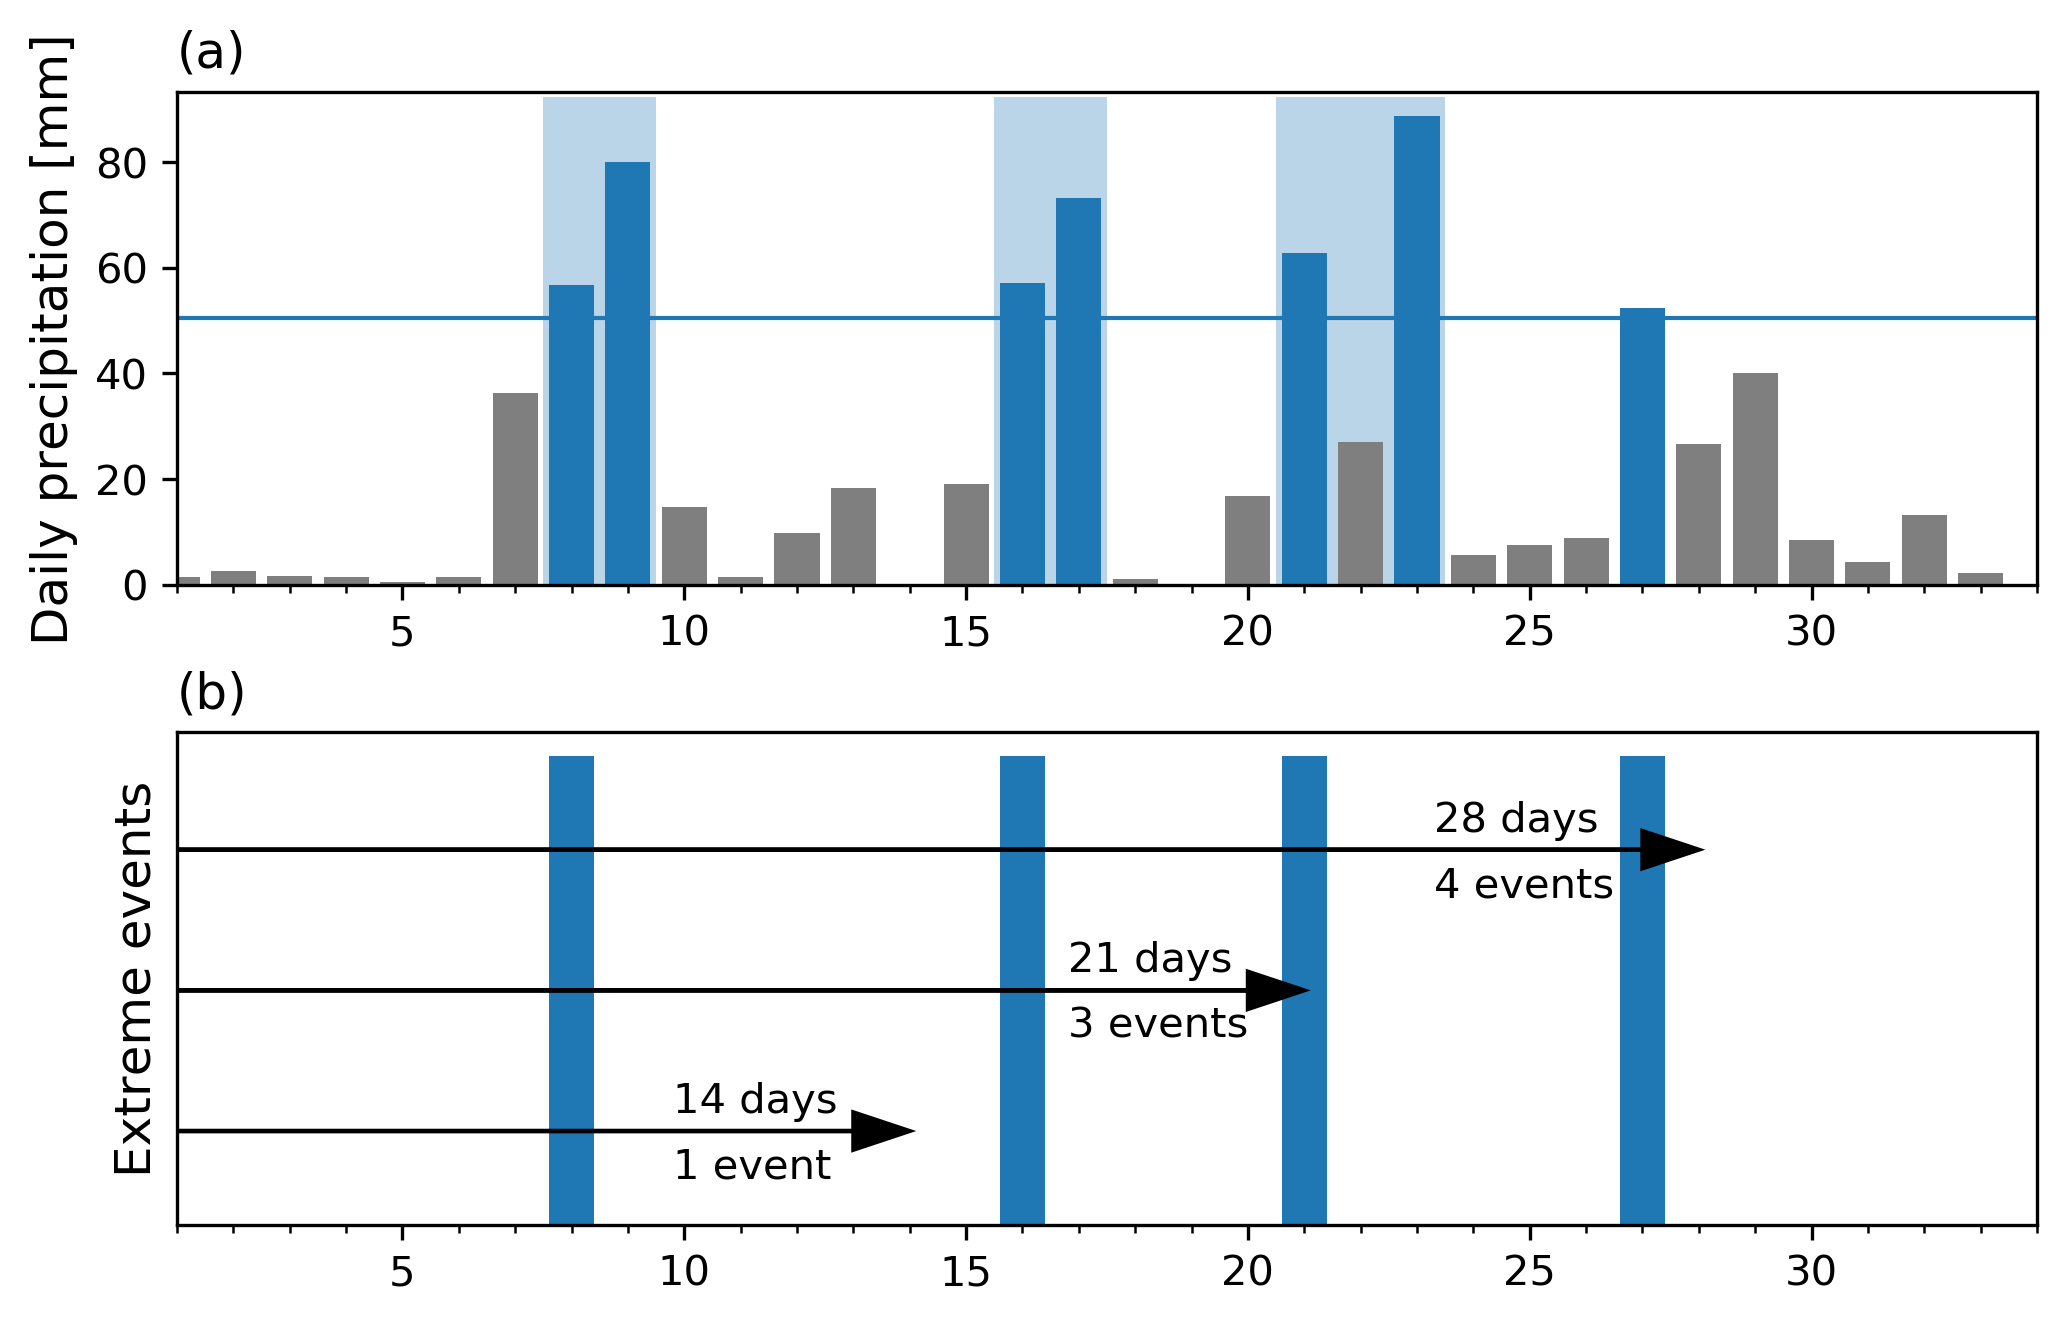

In [10]:
# Event selection
event = sel.iloc[0]
# Create time slice from dates
event['daynum'] = event.time.dayofyear - 258
evt_data['daynum'] = evt_data.time.dt.dayofyear - 258
#eps['daynum'] = eps.time.dt.dayofyear - 258
start_time = event.time - pd.Timedelta(days=15)
end_time = event.time + pd.Timedelta(days=18)
start_day = event.daynum - 15
end_day = event.daynum + 18
time_slice = slice(start_time, end_time)
#Data for precipitations histogram and POT dates
pr_data = evt_data[(evt_data.time >= start_time) & (evt_data.time < end_time)]

fts = 12

#Change time series values for example
TP_change1 = -15
TP_change2 = 40
dates = ('1993-10-11','1993-10-12','1993-10-13','1993-10-14','1993-10-15','1993-10-16','1993-10-17','1993-10-18')
pr_data.loc[pr_data.time==dates[3],['TP']] += TP_change1
for i in range(len(dates)):
    pr_data.loc[pr_data.time == pd.to_datetime(dates[i]),[tpw]] += TP_change2*i

fig = plt.figure(figsize=(8,5),dpi=300,constrained_layout=True)
gs = gridspec.GridSpec(nrows=2, ncols=1,hspace=0.3)#,width_ratios=widths,height_ratios=heights)

#Precipitation Histogram
ax1 = fig.add_subplot(gs[0, 0])
event_POT = pr_data[pr_data.TP >= pr_data.TH]
event_others = pr_data[pr_data.TP < pr_data.TH]
delta = 0.5
plt.axvspan(event_POT['daynum'].iloc[0]-delta,event_POT['daynum'].iloc[1]+delta,alpha=0.3,ymax=0.99)
plt.axvspan(event_POT['daynum'].iloc[2]-delta,event_POT['daynum'].iloc[3]+delta,alpha=0.3,ymax=0.99)
plt.axvspan(event_POT['daynum'].iloc[4]-delta,event_POT['daynum'].iloc[5]+delta,alpha=0.3,ymax=0.99)
ax1.bar(event_POT.daynum, event_POT.TP, align='center')
ax1.bar(event_others.daynum, event_others.TP, align='center',color='tab:grey')
ax1.set_xlim(start_day, end_day)
ax1.set_title('(a)',loc='left')
plt.axhline(y=pr_data['TH'].iloc[0],linewidth=1)
plt.ylabel('Daily precipitation [mm]', fontsize=fts)

#Event Histogram
ax4 = fig.add_subplot(gs[1, 0])
ax4.bar(pr_data.daynum, pr_data[thn], align='center')
ax4.set_xlim(start_day, end_day)
ax4.tick_params(axis='y',which='both',labelleft=False,left=False)
ax4.set_title('(b)',loc='left')
plt.ylabel('Extreme events', fontsize=fts)

x_tail = 0
y_tail = [0.2,0.5,0.8]
x_head = [13,20,27]
y_head = [0.2,0.5,0.8]
nudge = [-0.2,-0.2,-0.7]
dx = [x- x_tail for x in x_head] 
dy = tuple(map(lambda x, y: x - y, y_head, y_tail))
notes = ['14 days','21 days','28 days']
pks = ['1 event','3 events','4 events']
for i,j,k,l in zip(range(len(x_head)),range(len(notes)),range(len(pks)),range(len(nudge))):
    ax4.arrow(x_tail, y_tail[i], dx[i], dy[i], head_width=0.08, head_length=1, fc='k')
    ax4.text(x_head[i]-3+nudge[l],y_head[i]+0.04,notes[j],horizontalalignment='left',fontsize=10)
    ax4.text(x_head[i]-3+nudge[l],y_head[i]-0.1,pks[j],horizontalalignment='left',fontsize=10)

# Make some ticks and tick labels
ax4.yaxis.set_major_locator(MultipleLocator(1))
ax4.xaxis.set_major_locator(MultipleLocator(5))
ax4.xaxis.set_minor_locator(MultipleLocator(1))
ax1.xaxis.set_major_locator(MultipleLocator(5))
ax1.xaxis.set_minor_locator(MultipleLocator(1))